<a href="https://colab.research.google.com/github/jmisf14/Content-Based-Recommender/blob/main/A6_Serrano_JoseMiguel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A6 Content Based Recommender

### Set Up the environment

In [1]:
! pip install -q sentence_transformers

import numpy as np
import pandas as pd
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ast
from collections import Counter


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity




import spacy

from sentence_transformers import SentenceTransformer

In [2]:
def setup_kaggle():
  from google.colab import files
  uploaded = files.upload()
  !chmod 600 kaggle.json
  %mkdir -p /root/.kaggle/
  %mv kaggle.json /root/.kaggle/

setup_kaggle()

Saving kaggle.json to kaggle.json


In [3]:
!pip install -q kaggle

import kaggle
kaggle.api.authenticate()

In [4]:
import kaggle

dataset_path = 'tmdb/tmdb-movie-metadata'
kaggle.api.dataset_download_files(dataset_path, path=dataset_path, unzip=True)
!ls $dataset_path

Dataset URL: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
tmdb_5000_credits.csv  tmdb_5000_movies.csv


## Explore the Data

In [5]:
items_df = pd.read_csv(f'{dataset_path}/tmdb_5000_credits.csv')
items_df = items_df.set_index('title')
items_df.head()

,movie_id,cast,crew
title,,,
Avatar,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
Pirates of the Caribbean: At World's End,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
Spectre,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
The Dark Knight Rises,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
John Carter,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
items_df = pd.read_csv(f'{dataset_path}/tmdb_5000_movies.csv')
items_df = items_df.set_index('title')
items_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,vote_average,vote_count
title,,,,,,,,,,,,,,,,,,,
Avatar,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,7.2,11800
Pirates of the Caribbean: At World's End,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",6.9,4500
Spectre,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,6.3,4466
The Dark Knight Rises,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,7.6,9106
John Carter,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",6.1,2124


In [7]:
items_df.shape[0]

4803

In [8]:
items_df.dtypes

,0
budget,int64
genres,object
homepage,object
id,int64
keywords,object
original_language,object
original_title,object
overview,object
popularity,float64
production_companies,object


In [9]:
# movies and credits
movies_df = pd.read_csv('tmdb/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits_df = pd.read_csv('tmdb/tmdb-movie-metadata/tmdb_5000_credits.csv')

movies_df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [10]:
# Merge 'title' column
df = movies_df.merge(credits_df, left_on='title', right_on='title', how='left')

# look at merged dataset
df.shape, df.columns

((4809, 23),
 Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
        'original_title', 'overview', 'popularity', 'production_companies',
        'production_countries', 'release_date', 'revenue', 'runtime',
        'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
        'vote_count', 'movie_id', 'cast', 'crew'],
       dtype='object'))

### Numerical Columns

In [11]:
# List of numerical columns
numerical_cols = ['popularity', 'vote_count', 'vote_average', 'budget', 'revenue', 'runtime']

# Summary statistics
df[numerical_cols].describe()

,popularity,vote_count,vote_average,budget,revenue,runtime
count,4809.000000,4809.000000,4809.000000,4.809000e+03,4.809000e+03,4807.000000
mean,21.491664,690.331670,6.092514,2.902780e+07,8.227511e+07,106.882255
std,31.803366,1234.187111,1.193989,4.070473e+07,1.628379e+08,22.602535
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,4.667230,54.000000,5.600000,7.800000e+05,0.000000e+00,94.000000
50%,12.921594,235.000000,6.200000,1.500000e+07,1.917000e+07,103.000000
75%,28.350529,737.000000,6.800000,4.000000e+07,9.291317e+07,118.000000
max,875.581305,13752.000000,10.000000,3.800000e+08,2.787965e+09,338.000000


Numerical Columns: ['release_year', 'runtime', 'vote_average', 'vote_count']


,release_year,runtime,vote_average,vote_count
count,4808.000000,4807.000000,4809.000000,4809.000000
mean,2002.457363,106.882255,6.092514,690.331670
std,12.424628,22.602535,1.193989,1234.187111
min,1916.000000,0.000000,0.000000,0.000000
25%,1999.000000,94.000000,5.600000,54.000000
50%,2005.000000,103.000000,6.200000,235.000000
75%,2011.000000,118.000000,6.800000,737.000000
max,2017.000000,338.000000,10.000000,13752.000000


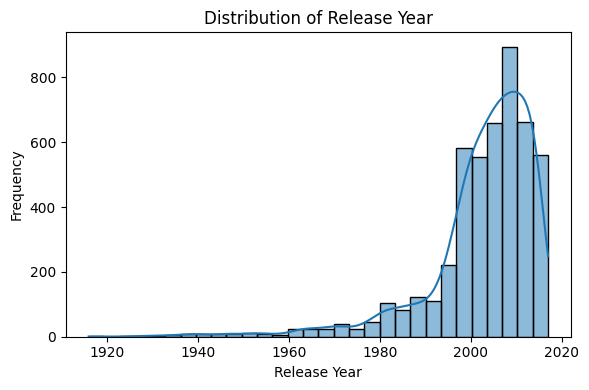

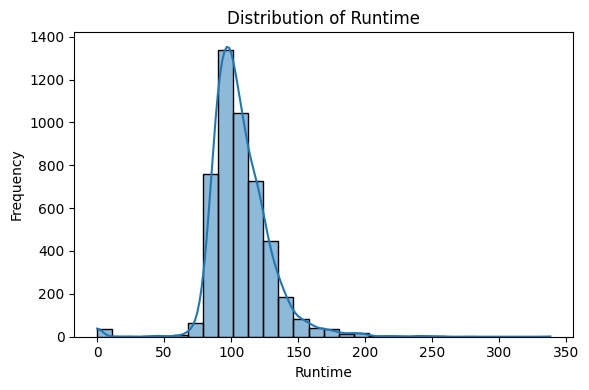

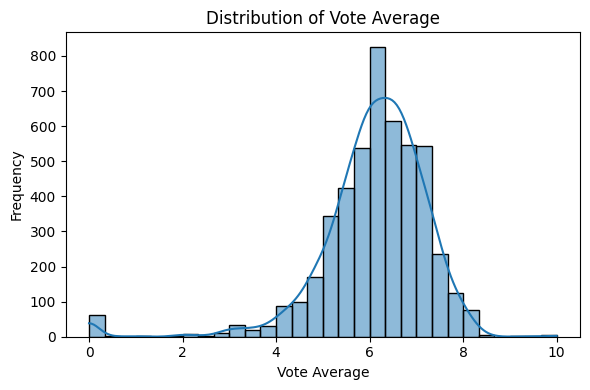

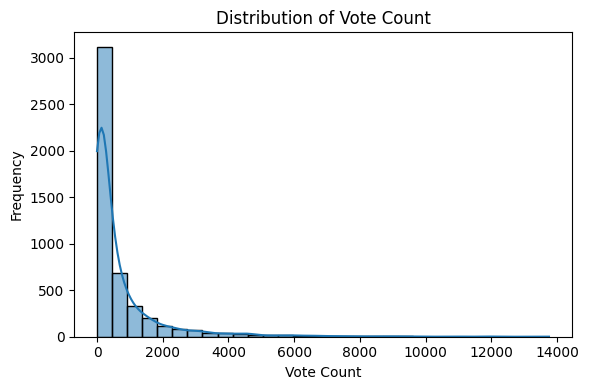

In [12]:
# release year from release_date
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

# relevant numerical columns
numerical_cols = ['release_year', 'runtime', 'vote_average', 'vote_count']
print("Numerical Columns:", numerical_cols)

# Summary statistics
display(df[numerical_cols].describe())

# Plot distributions
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### Categorical Columns

<Axes: title={'center': 'Top Genres'}, ylabel='Count'>

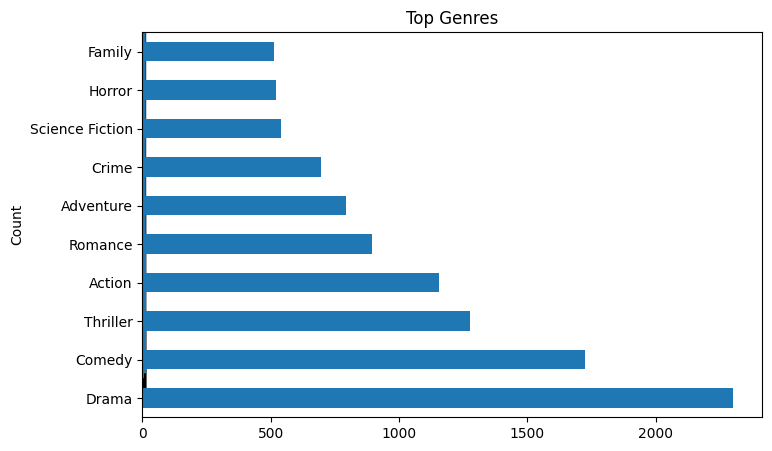

In [13]:
# Histogram: Vote Average
plt.figure(figsize=(8, 5))
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Distribution of Vote Averages')


def extract_names(data):
    return [i['name'] for i in ast.literal_eval(data)]

all_genres = df['genres'].dropna().apply(extract_names)
flat_genres = [g for sublist in all_genres for g in sublist]
genre_counts = Counter(flat_genres)

# plot top genres
pd.Series(genre_counts).sort_values(ascending=False).head(10).plot(kind='barh', title='Top Genres')

<Figure size 640x480 with 0 Axes>

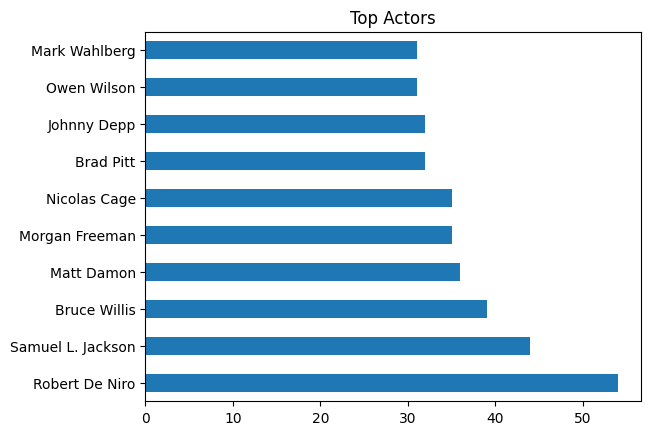

<Figure size 640x480 with 0 Axes>

In [14]:
# top 5 actors per movie
def get_top_cast(x):
    try:
        cast = ast.literal_eval(x)
        return [i['name'] for i in cast[:5]]
    except:
        return []

df['top_actors'] = df['cast'].apply(get_top_cast)
all_actors = [actor for sublist in df['top_actors'] for actor in sublist]
actor_counts = Counter(all_actors)
pd.Series(actor_counts).sort_values(ascending=False).head(10).plot(kind='barh', title='Top Actors')
plt.figure()

<Axes: title={'center': 'Top Directors'}, ylabel='director'>

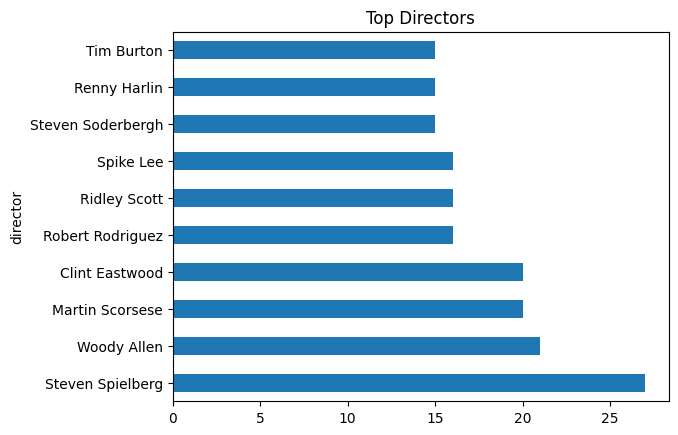

In [15]:
# movie director
def get_director(x):
    try:
        crew = ast.literal_eval(x)
        for member in crew:
            if member['job'] == 'Director':
                return member['name']
    except:
        return None

df['director'] = df['crew'].apply(get_director)
director_counts = df['director'].value_counts().head(10)

#plot

director_counts.plot(kind='barh', title='Top Directors')

### Text Columns

In [16]:
# Fill null values in overview
df['overview'] = df['overview'].fillna('')

# Display some examples
df[['title', 'overview']].sample(5)

,title,overview
4055,Fantasia,Walt Disney's timeless masterpiece is an extra...
2920,The Fighter,"The Fighter, is a drama about boxer ""Irish"" Mi..."
2339,Honey,Honey Daniels (Jessica Alba) dreams of making ...
1612,Hanna,A 16-year-old girl raised by her father to be ...
2068,Firefox,The Soviets have developed a revolutionary new...


In [17]:
# Add word count column
df['overview_word_count'] = df['overview'].apply(lambda x: len(x.split()))

# Summary statistics
print("Average words per overview:", df['overview_word_count'].mean())
print("Max words:", df['overview_word_count'].max())
print("Min words:", df['overview_word_count'].min())

Average words per overview: 52.150551050114366
Max words: 175
Min words: 0


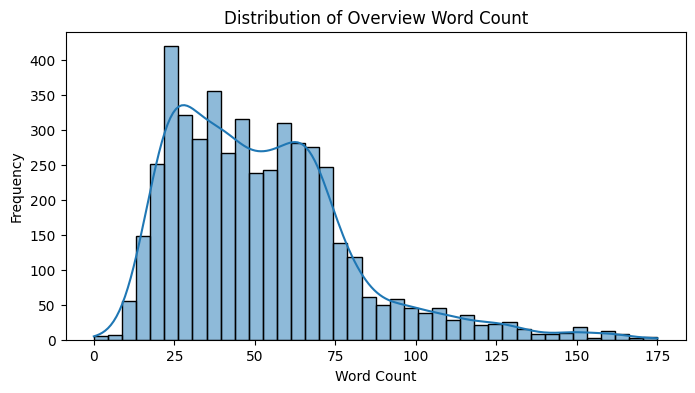

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(df['overview_word_count'], bins=40, kde=True)
plt.title("Distribution of Overview Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

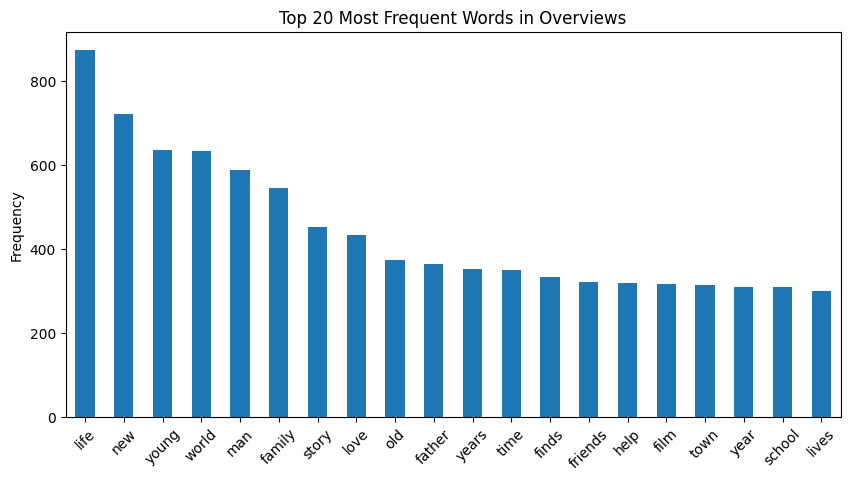

In [19]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['overview'])

# Sum word counts
words = vectorizer.get_feature_names_out()
counts = X.sum(axis=0).A1
word_freq = pd.Series(counts, index=words).sort_values(ascending=False)

# Plot most common words
plt.figure(figsize=(10, 5))
word_freq.plot(kind='bar')
plt.title("Top 20 Most Frequent Words in Overviews")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

## Similarity on Numerical Columns

### Without normalization

In [20]:
items_df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
count,4.803000e+03,4803.000000,4803.000000,4.803000e+03,4801.000000,4803.000000,4803.000000
mean,2.904504e+07,57165.484281,21.492301,8.226064e+07,106.875859,6.092172,690.217989
std,4.072239e+07,88694.614033,31.816650,1.628571e+08,22.611935,1.194612,1234.585891
min,0.000000e+00,5.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,7.900000e+05,9014.500000,4.668070,0.000000e+00,94.000000,5.600000,54.000000
50%,1.500000e+07,14629.000000,12.921594,1.917000e+07,103.000000,6.200000,235.000000
75%,4.000000e+07,58610.500000,28.313505,9.291719e+07,118.000000,6.800000,737.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000


In [21]:
# Define numerical columns
num_columns = ['runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']

# Include title for identification
items_num_df = df[['title'] + num_columns]

# Show the first few rows
items_num_df.head()

,title,runtime,vote_average,vote_count,popularity,release_year
0,Avatar,162.0,7.2,11800,150.437577,2009.0
1,Pirates of the Caribbean: At World's End,169.0,6.9,4500,139.082615,2007.0
2,Spectre,148.0,6.3,4466,107.376788,2015.0
3,The Dark Knight Rises,165.0,7.6,9106,112.312950,2012.0
4,John Carter,132.0,6.1,2124,43.926995,2012.0


In [22]:
# Select only the numerical features (exclude title for distance calculation)
items_num_values = items_num_df[num_columns]

# Compute pairwise Euclidean distances (allow NaNs)
euclidean_sim_num = pairwise_distances(
    items_num_values,
    items_num_values,
    metric='nan_euclidean',
    force_all_finite='allow-nan'
)

# Create a distance DataFrame with index and columns = movie titles
euclidean_sim_num_df = pd.DataFrame(
    euclidean_sim_num,
    index=items_num_df['title'],
    columns=items_num_df['title']
)

# Display shape and sample of the matrix
print("Distance matrix shape:", euclidean_sim_num_df.shape)
euclidean_sim_num_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Distance matrix shape: (4809, 4809)


title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
title,,,,,,,,,,,,,,,,,,,,,
Avatar,0.000000,7300.012467,7334.142284,2694.273120,9676.633232,8224.105873,8470.838167,5033.073326,6507.210435,4796.020945,...,11799.179503,11801.230539,11800.129258,11143.050571,11799.244420,11563.098029,11796.202704,11795.016532,11794.122714,11785.156399
Pirates of the Caribbean: At World's End,7300.012467,0.000000,51.639321,4606.082295,2378.197896,924.783086,1175.517982,2267.192147,794.181999,2504.136896,...,4500.843311,4502.992260,4501.697040,3844.846001,4501.029567,4264.761580,4497.917702,4496.378239,4495.689353,4486.793090
Spectre,7334.142284,51.639321,0.000000,4640.034920,2342.915900,890.120460,1138.539104,2301.168125,827.081199,2538.463756,...,4465.680740,4467.779620,4466.593617,3809.605482,4465.819796,4229.618305,4462.723200,4461.346226,4460.553421,4451.638243
The Dark Knight Rises,2694.273120,4606.082295,4640.034920,0.000000,6982.413042,5530.064680,5776.716536,2339.228208,3813.043710,2102.500869,...,9105.004946,9107.071954,9105.943903,8448.930961,9105.091940,8868.962367,9102.036869,9100.786679,9099.929452,9090.982351
John Carter,9676.633232,2378.197896,2342.915900,6982.413042,0.000000,1453.798259,1206.436198,4643.888884,3169.547782,4881.320579,...,2122.884589,2125.047809,2123.775829,1467.198277,2123.103058,1887.028564,2119.963345,2118.460426,2117.711072,2108.848216


In [23]:
# Now, try adding the distance column
recommendations_df = items_num_df.copy()

# Ensure 'title' is unique before using it for indexing
recommendations_df = recommendations_df[~recommendations_df.index.duplicated(keep='first')]
euclidean_sim_num_df = euclidean_sim_num_df[~euclidean_sim_num_df.index.duplicated(keep='first')]
euclidean_sim_num_df = euclidean_sim_num_df.loc[:, ~euclidean_sim_num_df.columns.duplicated(keep='first')]

recommendations_df['distance'] = euclidean_sim_num_df.loc['John Carter']
recommendations_df.sort_values('distance').head(10)

,title,runtime,vote_average,vote_count,popularity,release_year,distance
0,Avatar,162.0,7.2,11800,150.437577,2009.0,NaN
1,Pirates of the Caribbean: At World's End,169.0,6.9,4500,139.082615,2007.0,NaN
2,Spectre,148.0,6.3,4466,107.376788,2015.0,NaN
3,The Dark Knight Rises,165.0,7.6,9106,112.312950,2012.0,NaN
4,John Carter,132.0,6.1,2124,43.926995,2012.0,NaN
5,Spider-Man 3,139.0,5.9,3576,115.699814,2007.0,NaN
6,Tangled,100.0,7.4,3330,48.681969,2010.0,NaN
7,Avengers: Age of Ultron,141.0,7.3,6767,134.279229,2015.0,NaN
8,Harry Potter and the Half-Blood Prince,153.0,7.4,5293,98.885637,2009.0,NaN
9,Batman v Superman: Dawn of Justice,151.0,5.7,7004,155.790452,2016.0,NaN


### With normalization

In [24]:
# Define numerical columns
num_columns = ['runtime', 'vote_average', 'vote_count', 'popularity', 'release_year']

# Prepare data
items_num_df = df[['title'] + num_columns]

# Initialize scaler
sc = StandardScaler()

# Apply scaler to numerical features only
items_num_norm_df = pd.DataFrame(
    sc.fit_transform(items_num_df[num_columns]),
    columns=num_columns
)

# Store titles as index for future alignment
items_num_norm_df['title'] = items_num_df['title'].values
items_num_norm_df = items_num_norm_df.set_index('title')

# Describe normalized values
items_num_norm_df.describe()

,runtime,vote_average,vote_count,popularity,release_year
count,4.807000e+03,4.809000e+03,4.809000e+03,4.809000e+03,4.808000e+03
mean,2.601529e-16,-4.905390e-16,2.364043e-17,-4.728086e-17,8.204936e-15
std,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00,1.000104e+00
min,-4.729265e+00,-5.103186e+00,-5.593993e-01,-6.758372e-01,-6.959271e+00
25%,-5.700066e-01,-4.125375e-01,-5.156413e-01,-5.290693e-01,-2.782958e-01
50%,-1.717798e-01,9.003194e-02,-3.689708e-01,-2.694986e-01,2.046662e-01
75%,4.919316e-01,5.926014e-01,3.781694e-02,2.156872e-01,6.876283e-01
max,1.022637e+01,3.272972e+00,1.058432e+01,2.685811e+01,1.170590e+00


In [25]:
# Compute Euclidean distances on normalized data
euclidean_sim_num_norm = pairwise_distances(
    items_num_norm_df,
    items_num_norm_df,
    metric='nan_euclidean',
    force_all_finite='allow-nan'
)

# Create distance matrix DataFrame
euclidean_sim_num_norm_df = pd.DataFrame(
    euclidean_sim_num_norm,
    index=items_num_norm_df.index,
    columns=items_num_norm_df.index
)

print("Normalized distance matrix shape:", euclidean_sim_num_norm_df.shape)
euclidean_sim_num_norm_df.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Normalized distance matrix shape: (4809, 4809)


title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.685874e-07,5.941794,6.191772,2.528078,8.681343,6.917515,8.056525,4.242087,5.533316,4.155133,...,11.184473,12.756194,11.127546,10.576905,11.274054,11.003893,11.241084,10.810887,11.095228,11.127159
Pirates of the Caribbean: At World's End,5.941794e+00,0.000000,1.589180,3.895708,3.994019,1.888108,4.305259,2.336526,1.647204,2.561769,...,6.726911,8.986886,6.598410,6.291012,6.942224,6.634390,6.843958,6.077516,6.572006,6.655949
Spectre,6.191772e+00,1.589180,0.000000,3.996393,2.858383,1.128778,3.126650,2.233805,1.285118,2.612320,...,5.649215,7.803603,5.643386,5.236112,5.932387,5.708767,5.685034,5.105211,5.429694,5.588617
The Dark Knight Rises,2.528078e+00,3.895708,3.996393,0.000000,6.351810,4.858511,5.851214,2.306243,3.177024,2.791194,...,8.950710,10.995324,8.897438,8.403415,9.020153,8.846049,9.015781,8.411617,8.830081,8.878175
John Carter,8.681343e+00,3.994019,2.858383,6.351810,0.000000,2.600854,2.047888,4.843085,3.418867,5.379082,...,2.955948,5.988086,2.988567,2.935607,3.442323,3.326389,3.026638,2.363693,2.674467,2.908815


## Similarity on Categorical Columns

In [26]:
# Helper to parse JSON-like strings
def extract_names(text, top_n=None):
    try:
        data = ast.literal_eval(text)
        names = [d['name'] for d in data]
        return names[:top_n] if top_n else names
    except:
        return []

def get_director(crew_str):
    try:
        crew = ast.literal_eval(crew_str)
        for person in crew:
            if person['job'] == 'Director':
                return person['name']
    except:
        return ''

# Extract fields from df
df['Genre'] = df['genres'].apply(lambda x: ' '.join(extract_names(x)))
df['Director'] = df['crew'].apply(get_director)
df['Cast'] = df['cast'].apply(lambda x: extract_names(x, top_n=4))
df[['Star1', 'Star2', 'Star3', 'Star4']] = pd.DataFrame(df['Cast'].to_list(), index=df.index)

In [27]:
# Categorical columns to use
categorical_cols = ['Genre', 'Director', 'Star1', 'Star2', 'Star3', 'Star4']

items_cat_df = df[['title'] + categorical_cols].copy()
items_cat_df.set_index('title', inplace=True)

items_cat_df.fillna('', inplace=True)

# Lowercase, remove spaces and commas
items_cat_df = items_cat_df.apply(lambda col: col.str.lower().str.replace(' ', '').str.replace(',', ' ') if col.dtype == 'object' else col)

# Combine into one "soup" column
items_cat_df['soup'] = items_cat_df[categorical_cols].agg(' '.join, axis=1)

items_cat_df[['soup']].head()

,soup
title,
Avatar,actionadventurefantasysciencefiction jamescame...
Pirates of the Caribbean: At World's End,adventurefantasyaction goreverbinski johnnydep...
Spectre,actionadventurecrime sammendes danielcraig chr...
The Dark Knight Rises,actioncrimedramathriller christophernolan chri...
John Carter,actionadventuresciencefiction andrewstanton ta...


In [28]:
# Vectorize the "soup"
vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(items_cat_df['soup'])

# Compute cosine similarity matrix
cosine_sim_cat = cosine_similarity(count_matrix)

# Convert to DataFrame with titles as index/columns
cosine_sim_cat_df = pd.DataFrame(
    cosine_sim_cat,
    index=items_cat_df.index,
    columns=items_cat_df.index
)
cosine_sim_cat_df.head()

title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pirates of the Caribbean: At World's End,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spectre,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Dark Knight Rises,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
John Carter,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.166667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Reference movie
reference_movie = 'The Godfather: Part II'

# Check if title exists
if reference_movie in cosine_sim_cat_df.index:
    recommendations_cat_df = items_cat_df.copy()
    recommendations_cat_df['similarity'] = cosine_sim_cat_df.loc[reference_movie]
    display(recommendations_cat_df.sort_values('similarity', ascending=False).head(10))
else:
    print(f"'{reference_movie}' not found in the dataset.")

,Genre,Director,Star1,Star2,Star3,Star4,soup,similarity
title,,,,,,,,
The Godfather: Part II,dramacrime,francisfordcoppola,alpacino,robertduvall,dianekeaton,robertdeniro,dramacrime francisfordcoppola alpacino robertd...,1.000000
The Godfather: Part III,crimedramathriller,francisfordcoppola,alpacino,dianekeaton,andygarcía,taliashire,crimedramathriller francisfordcoppola alpacino...,0.500000
The Godfather,dramacrime,francisfordcoppola,marlonbrando,alpacino,jamescaan,richards.castellano,dramacrime francisfordcoppola marlonbrando alp...,0.462910
Apocalypse Now,dramawar,francisfordcoppola,martinsheen,marlonbrando,robertduvall,fredericforrest,dramawar francisfordcoppola martinsheen marlon...,0.333333
GoodFellas,dramacrime,martinscorsese,robertdeniro,rayliotta,joepesci,lorrainebracco,dramacrime martinscorsese robertdeniro rayliot...,0.333333
Casino,dramacrime,martinscorsese,robertdeniro,sharonstone,joepesci,jameswoods,dramacrime martinscorsese robertdeniro sharons...,0.333333
The Big Wedding,comedy,justinzackham,robertdeniro,dianekeaton,katherineheigl,amandaseyfried,comedy justinzackham robertdeniro dianekeaton ...,0.333333
Mean Streets,dramacrime,martinscorsese,harveykeitel,robertdeniro,davidproval,amyrobinson,dramacrime martinscorsese harveykeitel robertd...,0.333333
Righteous Kill,actioncrimedramathriller,jonavnet,robertdeniro,carlagugino,50cent,alpacino,actioncrimedramathriller jonavnet robertdeniro...,0.333333


## Similarity on Text Columns

### Vectorization

#### Bag of Words

In [30]:
# Fill missing overviews with empty string
df['overview'] = df['overview'].fillna('')

# Optional: lowercase (not strictly necessary for CountVectorizer with stop_words)
df['overview_clean'] = df['overview'].str.lower()

# Show preview
df[['title', 'overview_clean']].head()

,title,overview_clean
0,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,Spectre,a cryptic message from bond’s past sends him o...
3,The Dark Knight Rises,following the death of district attorney harve...
4,John Carter,"john carter is a war-weary, former military ca..."


In [31]:

# Initialize CountVectorizer
bow_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the cleaned overviews
bow_matrix = bow_vectorizer.fit_transform(df['overview_clean'])

# Show matrix shape (num_movies x num_unique_words)
print("BoW matrix shape:", bow_matrix.shape)

BoW matrix shape: (4809, 20978)


In [32]:
# Compute cosine similarity between all movies
cosine_sim_bow = cosine_similarity(bow_matrix)

# Turn into DataFrame with movie titles
cosine_sim_bow_df = pd.DataFrame(
    cosine_sim_bow,
    index=df['title'],
    columns=df['title']
)

cosine_sim_bow_df.head()

title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.000000,0.000000,0.0,0.034816,0.000000,0.044281,0.000000,0.042448,0.000000,0.000000,...,0.000000,0.0,0.031782,0.047946,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Pirates of the Caribbean: At World's End,0.000000,1.000000,0.0,0.000000,0.046524,0.000000,0.000000,0.043937,0.000000,0.000000,...,0.000000,0.0,0.032898,0.000000,0.000000,0.0,0.0,0.039841,0.000000,0.000000
Spectre,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.032880,0.043644,0.000000,...,0.057735,0.0,0.000000,0.000000,0.021442,0.0,0.0,0.029814,0.000000,0.000000
The Dark Knight Rises,0.034816,0.000000,0.0,1.000000,0.023473,0.023125,0.035109,0.022168,0.029424,0.151142,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.040202,0.059005,0.063175
John Carter,0.000000,0.046524,0.0,0.023473,1.000000,0.000000,0.022663,0.057236,0.000000,0.055749,...,0.050252,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.025950,0.000000,0.000000


In [33]:
df['overview'] = df['overview'].fillna('')

In [34]:
df['overview_clean'] = df['overview'].str.lower()

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(df['overview_clean'])

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_bow = cosine_similarity(bow_matrix)
cosine_sim_bow_df = pd.DataFrame(cosine_sim_bow, index=df['title'], columns=df['title'])

In [37]:
default_stop_words = list(bow_vectorizer.get_stop_words())
print(default_stop_words[:20])

['eg', 'every', 'own', 'detail', 'out', 'both', 're', 'down', 'because', 'hereby', 'anyone', 'with', 'here', 'if', 'mine', 'were', 'hundred', 'during', 'seems', 'six']


Unique word counts: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10)}


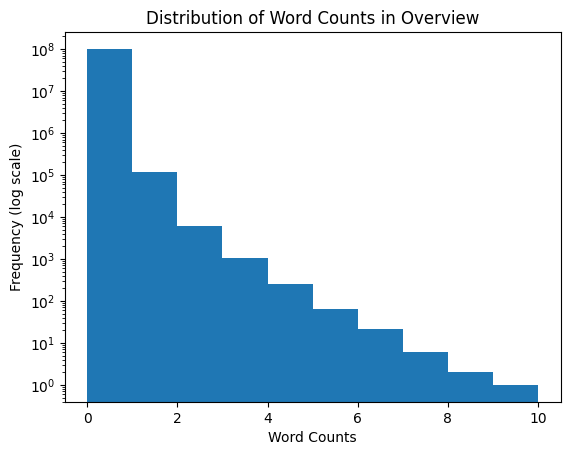

In [38]:
# Get unique word counts
unique_word_counts = set(bow_matrix.toarray().flatten())
print("Unique word counts:", unique_word_counts)

# Plot histogram with logarithmic scale
plt.hist(bow_matrix.toarray().flatten(), log=True)
plt.xlabel("Word Counts")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Word Counts in Overview")
plt.show()

In [39]:
bow_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(df['overview_clean'])

In [40]:
# Create BoW matrix as DataFrame
count_matrix_bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns=bow_vectorizer.get_feature_names_out(),
    index=df['title']
)

# top of matrix
count_matrix_bow_df.head()

,00,000,007,07am,10,100,1000,101,108,10th,...,zuckerberg,zula,zuzu,zyklon,æon,éloigne,émigré,été,única,über
title,,,,,,,,,,,,,,,,,,,,,
Avatar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pirates of the Caribbean: At World's End,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectre,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Dark Knight Rises,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Carter,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df.loc[df['title'] == 'The Dark Knight Rises', 'overview'].values[0]

"Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted by the Gotham City Police Department. Eight years later, Batman encounters the mysterious Selina Kyle and the villainous Bane, a new terrorist leader who overwhelms Gotham's finest. The Dark Knight resurfaces to protect a city that has branded him an enemy."

In [42]:
count_matrix_bow_df.loc['The Dark Knight Rises', count_matrix_bow_df.loc['The Dark Knight Rises'] != 0]

,The Dark Knight Rises
assumes,1
attorney,2
bane,1
batman,2
branded,1
city,2
crimes,1
dark,1
death,1
dent,2


#### TF-IDF

In [43]:
df['overview'] = df['overview'].fillna('')
df['overview_clean'] = df['overview'].str.lower()

In [44]:
# Initialize TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer_tfidf.fit_transform(df['overview_clean'])

print(tfidf_matrix.shape)

(4809, 20978)


In [45]:
cosine_sim_tfidf = cosine_similarity(tfidf_matrix)

cosine_sim_tfidf_df = pd.DataFrame(
    cosine_sim_tfidf,
    index=df['title'],
    columns=df['title']
)
cosine_sim_tfidf_df.head()

title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter,Spider-Man 3,Tangled,Avengers: Age of Ultron,Harry Potter and the Half-Blood Prince,Batman v Superman: Dawn of Justice,...,On The Downlow,Sanctuary: Quite a Conundrum,Bang,Primer,Cavite,El Mariachi,Newlyweds,"Signed, Sealed, Delivered",Shanghai Calling,My Date with Drew
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1.000000,0.000000,0.0,0.025042,0.000000,0.03018,0.000000,0.037591,0.000000,0.000000,...,0.000000,0.0,0.029185,0.042214,0.000000,0.0,0.0,0.000000,0.000000,0.000000
Pirates of the Caribbean: At World's End,0.000000,1.000000,0.0,0.000000,0.033376,0.00000,0.000000,0.022607,0.000000,0.000000,...,0.000000,0.0,0.006899,0.000000,0.000000,0.0,0.0,0.021610,0.000000,0.000000
Spectre,0.000000,0.000000,1.0,0.000000,0.000000,0.00000,0.000000,0.030964,0.024855,0.000000,...,0.027648,0.0,0.000000,0.000000,0.017776,0.0,0.0,0.014891,0.000000,0.000000
The Dark Knight Rises,0.025042,0.000000,0.0,1.000000,0.010453,0.00515,0.012627,0.026999,0.020599,0.132393,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.033921,0.042821,0.022731
John Carter,0.000000,0.033376,0.0,0.010453,1.000000,0.00000,0.009343,0.037415,0.000000,0.017137,...,0.012724,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.006122,0.000000,0.000000


In [46]:
df.loc[df['title'] == 'John Carter', 'overview'].values[0]

"John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands."

In [47]:
movie_title = 'John Carter'

# Create a DataFrame from the TF-IDF matrix
count_matrix_tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer_tfidf.get_feature_names_out(),
    index=df['title']
)

if movie_title in count_matrix_tfidf_df.index:
    non_zero_tfidf = count_matrix_tfidf_df.loc[movie_title]
    non_zero_tfidf = non_zero_tfidf[non_zero_tfidf > 0]
    display(non_zero_tfidf.sort_values(ascending=False))
else:
    print(f"'{movie_title}' not found in TF-IDF matrix.")

,John Carter
barsoom,0.468433
carter,0.343058
rests,0.223407
rediscovers,0.209788
weary,0.200818
inexplicably,0.197258
embroiled,0.191309
mars,0.186448
collapse,0.184314
transported,0.184314


#### Lemmatization

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [49]:
movie_title = 'John Carter'

if movie_title in items_df.index:
    # Get the text
    text = items_df.loc[items_df.index == movie_title, 'overview'].values[0]

    # Process the text using spaCy
    doc = nlp(text)

    # Extract lemmatized tokens. skip punctuation and stopwords
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

    lemmatized_text = ' '.join(lemmatized_tokens)

    # Print results
    print("Original Text:\n", text)
    print("\nLemmatized Text:\n", lemmatized_text)
else:
    print(f"'{movie_title}' not found in items_df.")

Original Text:
 John Carter is a war-weary, former military captain who's inexplicably transported to the mysterious and exotic planet of Barsoom (Mars) and reluctantly becomes embroiled in an epic conflict. It's a world on the brink of collapse, and Carter rediscovers his humanity when he realizes the survival of Barsoom and its people rests in his hands.

Lemmatized Text:
 John Carter be a war weary former military captain who be inexplicably transport to the mysterious and exotic planet of Barsoom Mars and reluctantly becomes embroil in an epic conflict it be a world on the brink of collapse and Carter rediscover his humanity when he realize the survival of Barsoom and its people rest in his hand


In [50]:
lemmatized_texts = []
for index in tqdm(items_df.index):
    overview = items_df.loc[index, 'overview']
    if isinstance(overview, pd.Series):
        overview = overview.iloc[0]
    if isinstance(overview, float):
        overview = ''
    doc = nlp(overview)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    lemmatized_texts.append(lemmatized_text)

items_df['Overview_Lem'] = lemmatized_texts

100%|██████████| 4803/4803 [01:35<00:00, 50.39it/s]


In [51]:
display(items_df[['overview', 'Overview_Lem']].head())

,overview,Overview_Lem
title,,
Avatar,"In the 22nd century, a paraplegic Marine is di...","in the 22nd century , a paraplegic Marine be d..."
Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","Captain Barbossa , long believe to be dead , h..."
Spectre,A cryptic message from Bond’s past sends him o...,a cryptic message from Bond ’s past send he on...
The Dark Knight Rises,Following the death of District Attorney Harve...,follow the death of District Attorney Harvey D...
John Carter,"John Carter is a war-weary, former military ca...","John Carter be a war - weary , former military..."


In [52]:
count_matrix_tfidf_lem = vectorizer_tfidf.fit_transform(items_df['Overview_Lem'])

In [53]:
count_matrix_tfidf_lem_df = pd.DataFrame(count_matrix_tfidf_lem.toarray(), columns=vectorizer_tfidf.get_feature_names_out())
count_matrix_tfidf_lem_df.index = items_df.index

In [54]:
count_matrix_tfidf_lem.shape

(4803, 17350)

In [55]:
df['overview'] = df['overview'].fillna('')
df['overview_clean'] = df['overview'].str.lower()

from sklearn.feature_extraction.text import TfidfVectorizer

#TF-IDF vectorizer
vectorizer_tfidf = TfidfVectorizer(stop_words='english')

count_matrix_tfidf = vectorizer_tfidf.fit_transform(df['overview_clean'])
print(count_matrix_tfidf.shape)

(4809, 20978)


In [56]:
df.loc[df['title'] == 'Spectre', 'overview'].values[0]

'A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. While M battles political forces to keep the secret service alive, Bond peels back the layers of deceit to reveal the terrible truth behind SPECTRE.'

#### BERT

In [59]:
# Convert any floats in 'overview' column to strings
items_df['overview'] = items_df['overview'].astype(str)

# Now proceed with encoding
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(items_df['overview'], show_progress_bar=False)

/usr/local/lib/python3.11/dist-packages/sentence_transformers/SentenceTransformer.py:587: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentences_sorted = [sentences[idx] for idx in length_sorted_idx]


In [60]:
embeddings.shape

(4803, 768)

In [61]:
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.index = items_df.index
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
title,,,,,,,,,,,,,,,,,,,,,
Avatar,-0.714226,-0.605697,0.336799,-0.783155,-0.891479,-0.602954,-0.337711,0.142923,0.506889,0.352970,...,-0.592471,0.370967,-0.412509,0.484847,0.143952,-0.332331,-0.023392,-0.196710,0.230480,-0.499830
Pirates of the Caribbean: At World's End,-0.659816,-0.630460,0.825353,-1.066315,-0.117229,-0.747783,-0.318497,0.066654,0.914651,0.132173,...,0.385093,-0.084137,0.346514,0.752653,0.547243,-0.257570,-0.234337,-0.245253,0.135287,-1.068730
Spectre,-0.483091,-0.488950,0.304479,-0.742951,-0.137619,-0.376421,0.490102,-0.678703,0.730885,0.384279,...,-0.275177,0.728014,0.231787,0.772029,0.328647,0.022230,-0.074662,-0.216244,0.144557,-0.579677
The Dark Knight Rises,-0.671517,-0.616389,0.450451,-1.513773,-0.398943,-0.446042,0.242871,-0.577650,0.313156,0.174459,...,-0.132031,0.445308,-0.000141,1.319167,0.110122,-0.305944,-0.262542,-0.235944,0.389599,-1.473535
John Carter,-0.708718,-0.725962,0.564695,-1.160799,-0.484123,-0.933888,-1.033726,-0.394830,0.516342,0.041859,...,0.178846,0.480555,0.437140,0.015250,0.226304,-0.580406,-0.225578,-0.168098,0.422573,-1.183850


### Similarities

In [62]:
print(count_matrix_bow_df.shape)
print(count_matrix_tfidf_df.shape)
print(count_matrix_tfidf_lem_df.shape)
print(embeddings_df.shape)

(4809, 20978)
(4809, 20978)
(4803, 17350)
(4803, 768)


In [63]:
def compute_similarities(vectorization_df):
  sim = pairwise_distances(vectorization_df, vectorization_df, metric='cosine')
  # Use the index of the input DataFrame instead of items_df
  sim_df = pd.DataFrame(sim, columns=vectorization_df.index, index=vectorization_df.index)
  return sim_df

In [64]:
bow_sim_df = compute_similarities(count_matrix_bow_df)
tfidf_sim_df = compute_similarities(count_matrix_tfidf_df)
tfidf_lem_sim_df = compute_similarities(count_matrix_tfidf_lem_df)
bert_sim_df = compute_similarities(embeddings_df)

In [65]:
print(bow_sim_df.shape)
print(tfidf_sim_df.shape)
print(tfidf_lem_sim_df.shape)
print(bert_sim_df.shape)

(4809, 4809)
(4809, 4809)
(4803, 4803)
(4803, 4803)


In [66]:
def top_n(sim_df, item, n):
  recommendations_df = items_df[['overview']].copy()
  recommendations_df = recommendations_df[~recommendations_df.index.duplicated(keep='first')]
  sim_df = sim_df[~sim_df.index.duplicated(keep='first')]

  recommendations_df = recommendations_df.reset_index()
  sim_df = sim_df.reset_index()

  recommendations_df = pd.merge(recommendations_df, sim_df[[sim_df.columns[0], item]], left_on='title', right_on=sim_df.columns[0], how='left')
  recommendations_df = recommendations_df.set_index('title')
  recommendations_df = recommendations_df.rename(columns={item: 'distance'})
  recommendations_df = recommendations_df.sort_values('distance').head(n)

  return recommendations_df

In [67]:
# BoW
bow_recommendations = top_n(bow_sim_df, "Avatar", 10)
print("BoW Recommendations:")
display(bow_recommendations)

BoW Recommendations:


,overview,distance
title,,
Avatar,"In the 22nd century, a paraplegic Marine is di...",2.220446e-16
Apollo 18,"Officially, Apollo 17 was the last manned miss...",7.715839e-01
Tears of the Sun,Navy SEAL Lieutenant A.K. Waters and his elite...,8.509288e-01
The American,Dispatched to a small Italian town to await fu...,8.567770e-01
Beowulf,"6th-century Scandinavian warrior, Beowulf emba...",8.567770e-01
The Inhabited Island,"On the threshold of 22nd century, furrowing th...",8.651600e-01
The Matrix,"Set in the 22nd century, The Matrix tells the ...",8.782839e-01
Aliens vs Predator: Requiem,"A sequel to 2004's Alien vs. Predator, the ico...",8.815302e-01
Hanna,A 16-year-old girl raised by her father to be ...,8.845299e-01


In [68]:
# TF-IDF
tfidf_recommendations = top_n(tfidf_sim_df, "Avatar", 10)
print("\nTF-IDF Recommendations:")
display(tfidf_recommendations)


TF-IDF Recommendations:


,overview,distance
title,,
Avatar,"In the 22nd century, a paraplegic Marine is di...",1.110223e-16
Apollo 18,"Officially, Apollo 17 was the last manned miss...",8.132971e-01
The American,Dispatched to a small Italian town to await fu...,8.298018e-01
The Matrix,"Set in the 22nd century, The Matrix tells the ...",8.676640e-01
The Inhabited Island,"On the threshold of 22nd century, furrowing th...",8.760295e-01
Tears of the Sun,Navy SEAL Lieutenant A.K. Waters and his elite...,8.774842e-01
Hanna,A 16-year-old girl raised by her father to be ...,8.953517e-01
The Adventures of Pluto Nash,"The year is 2087, the setting is the moon. Plu...",8.990627e-01
Semi-Pro,"Jackie Moon is the owner, promoter, coach, and...",9.019869e-01


In [69]:
# TF-IDF with Lemmatization
tfidf_lem_recommendations = top_n(tfidf_lem_sim_df, "Avatar", 10)
print("\nTF-IDF with Lemmatization Recommendations:")
display(tfidf_lem_recommendations)


TF-IDF with Lemmatization Recommendations:


,overview,distance
title,,
Avatar,"In the 22nd century, a paraplegic Marine is di...",0.000000
Apollo 18,"Officially, Apollo 17 was the last manned miss...",0.791528
The Matrix,"Set in the 22nd century, The Matrix tells the ...",0.860749
The American,Dispatched to a small Italian town to await fu...,0.864135
Tears of the Sun,Navy SEAL Lieutenant A.K. Waters and his elite...,0.866145
The Inhabited Island,"On the threshold of 22nd century, furrowing th...",0.867962
Hanna,A 16-year-old girl raised by her father to be ...,0.887012
The Adventures of Pluto Nash,"The year is 2087, the setting is the moon. Plu...",0.887643
Dolphin Tale 2,The team of people who saved Winter's life rea...,0.890861


In [70]:
# BERT
bert_recommendations = top_n(bert_sim_df, "Avatar", 10)
print("\nBERT Recommendations:")
display(bert_recommendations)


BERT Recommendations:


,overview,distance
title,,
Avatar,"In the 22nd century, a paraplegic Marine is di...",5.960464e-08
The Black Hole,The explorer craft U.S.S. Palomino is returnin...,1.139079e-01
The Inhabited Island,"On the threshold of 22nd century, furrowing th...",1.178454e-01
Star Trek IV: The Voyage Home,Fugitives of the Federation for their daring r...,1.266919e-01
Monsters,Six years ago NASA discovered the possibility ...,1.396748e-01
Escape from Planet Earth,Astronaut Scorch Supernova finds himself caugh...,1.407311e-01
Galaxy Quest,The stars of a 1970s sci-fi show - now scrapin...,1.407791e-01
Journey to Saturn,A Danish crew of misfits travel to Saturn in s...,1.425737e-01
Ghosts of Mars,Melanie Ballard (Natasha Henstridge) is a hard...,1.432649e-01


### Interpretation: PCA to project items in a 2-D space

In [71]:
sc = StandardScaler()
embeddings_norm = sc.fit_transform(embeddings)

In [72]:
embeddings_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,...,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000
mean,-0.343478,-0.470334,0.316939,-0.849222,-0.184773,-0.341082,-0.129469,-0.451843,0.719198,0.326164,...,-0.308731,-0.230797,0.039702,0.447701,0.062177,-0.276033,-0.005645,-0.238992,0.225171,-0.613553
std,0.356954,0.266031,0.347337,0.362270,0.287983,0.255295,0.345678,0.311103,0.415146,0.405320,...,0.350402,0.532599,0.415601,0.440834,0.252057,0.428517,0.242993,0.310254,0.308466,0.401313
min,-1.763921,-1.628758,-1.363894,-2.496706,-1.413554,-1.270530,-1.122828,-1.611314,-0.897992,-1.250286,...,-1.507434,-1.878299,-1.545514,-1.242167,-0.991877,-1.806875,-0.998167,-1.380036,-0.850511,-1.983685
25%,-0.578728,-0.645219,0.086269,-1.085735,-0.371984,-0.509910,-0.367685,-0.655030,0.461045,0.056785,...,-0.538457,-0.596741,-0.231592,0.152878,-0.107866,-0.569661,-0.167652,-0.448662,0.017304,-0.890158
50%,-0.342214,-0.463729,0.312349,-0.842854,-0.184188,-0.329514,-0.153127,-0.464650,0.727225,0.331177,...,-0.315270,-0.203152,0.034267,0.442655,0.063180,-0.284169,-0.008219,-0.252405,0.232956,-0.600692
75%,-0.108683,-0.289795,0.542828,-0.606896,0.001345,-0.163203,0.087082,-0.256648,0.997091,0.602414,...,-0.082107,0.156200,0.305526,0.736102,0.229021,0.010016,0.153588,-0.034479,0.437665,-0.333205
max,1.299434,0.410350,1.908500,0.776566,0.818129,0.556216,1.422056,1.115367,2.124213,2.229786,...,1.036672,1.546737,2.076201,2.320899,1.003918,1.664986,1.034801,1.197824,1.490962,0.742025


In [73]:
pd.DataFrame(embeddings_norm).describe()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,4803.000000,4.803000e+03,4.803000e+03,4803.000000,4.803000e+03,4.803000e+03,4803.000000,4.803000e+03,4.803000e+03,4.803000e+03,...,4.803000e+03,4803.000000,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03,4.803000e+03
mean,0.000000,1.588464e-09,3.176929e-09,0.000000,3.176929e-09,6.353857e-09,0.000000,-5.559625e-09,3.176929e-09,-3.176929e-09,...,-1.588464e-09,0.000000,9.530787e-09,6.353857e-09,-7.942322e-10,-1.270771e-08,8.736555e-09,1.270771e-08,-3.176929e-09,-3.176929e-09
std,1.000104,1.000103e+00,1.000104e+00,1.000105,1.000104e+00,1.000104e+00,1.000104,1.000103e+00,1.000104e+00,1.000104e+00,...,1.000104e+00,1.000104,1.000104e+00,1.000104e+00,1.000103e+00,1.000104e+00,1.000103e+00,1.000104e+00,1.000105e+00,1.000103e+00
min,-3.979764,-4.354922e+00,-4.839708e+00,-4.548144,-4.267294e+00,-3.641068e+00,-2.873949,-3.727352e+00,-3.895878e+00,-3.889800e+00,...,-3.421292e+00,-3.093651,-3.814674e+00,-3.833739e+00,-4.182246e+00,-3.572793e+00,-4.084994e+00,-3.678153e+00,-3.487557e+00,-3.414481e+00
25%,-0.659118,-6.574545e-01,-6.641806e-01,-0.652933,-6.501453e-01,-6.613770e-01,-0.689198,-6.531860e-01,-6.219012e-01,-6.646786e-01,...,-6.556762e-01,-0.687163,-6.528448e-01,-6.688523e-01,-6.746910e-01,-6.852906e-01,-6.667872e-01,-6.758713e-01,-6.739435e-01,-6.893240e-01
50%,0.003540,2.483193e-02,-1.321618e-02,0.017580,2.031003e-03,4.531884e-02,-0.068447,-4.117234e-02,1.933922e-02,1.236975e-02,...,-1.866221e-02,0.051911,-1.308079e-02,-1.144792e-02,3.978695e-03,-1.898807e-02,-1.059796e-02,-4.323942e-02,2.523797e-02,3.204957e-02
75%,0.657843,6.787107e-01,6.504129e-01,0.668980,6.463477e-01,6.968331e-01,0.626518,6.274908e-01,6.694553e-01,6.816301e-01,...,6.468214e-01,0.726696,6.396793e-01,6.542843e-01,6.619985e-01,6.676026e-01,6.553626e-01,6.592444e-01,6.889437e-01,6.986493e-01
max,4.603071,3.310801e+00,4.582662e+00,4.488249,3.482864e+00,3.515122e+00,4.488817,5.038107e+00,3.384740e+00,4.697078e+00,...,3.839996e+00,3.337820,4.900644e+00,4.249651e+00,3.736616e+00,4.530095e+00,4.282236e+00,4.631569e+00,4.103926e+00,3.378211e+00


In [74]:
pca = PCA()
pca.fit_transform(embeddings_norm);

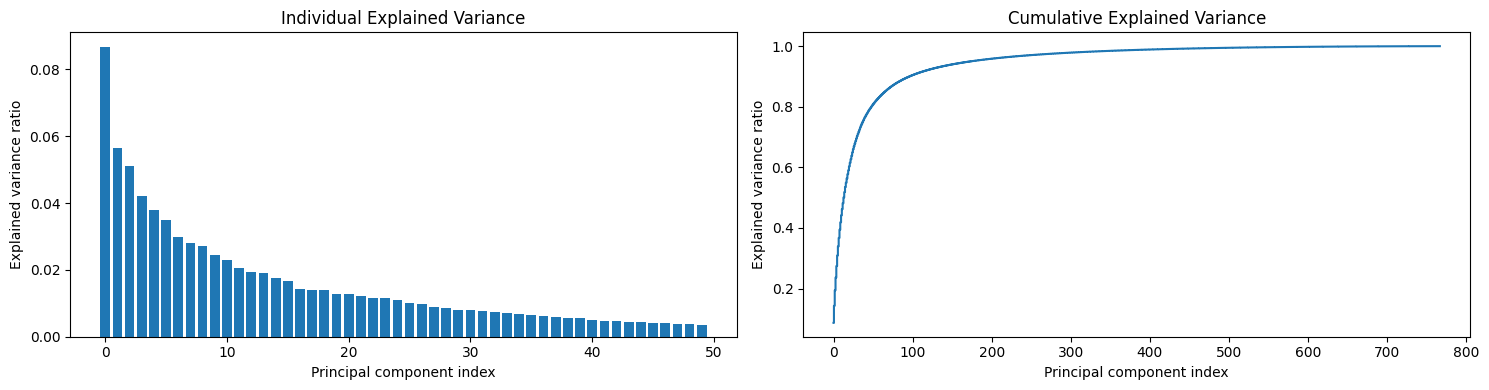

In [77]:
pca = PCA()
embeddings_pca = pca.fit_transform(embeddings_norm)
exp_var_pca = pca.explained_variance_ratio_ # Assign explained variance to exp_var_pca

cum_sum_eigenvalues = np.cumsum(exp_var_pca) # Calculate cumulative explained variance

plt.figure(figsize=(15, 4))

# Individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(50), exp_var_pca[:50], align='center', label='Individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Individual Explained Variance')

# Cumulative explained variance
plt.subplot(1, 2, 2)
plt.step(range(len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()

In [78]:
pca = PCA(n_components=2)
embeddings_2D = pca.fit_transform(embeddings_norm)

In [79]:
df_aux = pd.DataFrame(zip(embeddings_2D[:, 0], embeddings_2D[:, 1], items_df.index))
fig = px.scatter(df_aux, x=0, y=1, hover_data=[2], width=800, height=800)
fig.show()

# Random Recommender

In [80]:
import random

num_recommendations = 10

In [81]:
def random_recommender(items_df, exclude_title=None, n=10):
    available_titles = items_df.index.tolist()

    if exclude_title and exclude_title in available_titles:
        available_titles.remove(exclude_title)

    return random.sample(available_titles, min(n, len(available_titles)))

In [82]:
reference_title = 'Avatar'
random_recommendations = random_recommender(items_df, exclude_title=reference_title, n=num_recommendations)

print(f"Random recommendations (excluding '{reference_title}'):")
for i, title in enumerate(random_recommendations, 1):
    print(f"{i}. {title}")

Random recommendations (excluding 'Avatar'):
1. The Omen
2. Sweet November
3. Nothing to Lose
4. Memoirs of an Invisible Man
5. A Dangerous Method
6. East Is East
7. Poetic Justice
8. My All American
9. Poltergeist III
10. GoodFellas


In [83]:
# Simulated user history
user_history = [
    'The Dark Knight Rises',
    'Inception',
    'Interstellar'
]

In [84]:
user_vector = cosine_sim_tfidf_df.loc[user_history].mean(axis=0)

user_vector = user_vector.drop(labels=user_history)

In [85]:
top_n = 10

recommendations_df = user_vector.sort_values(ascending=False).head(top_n).reset_index()
recommendations_df.columns = ['title', 'similarity']
recommendations_df

,title,similarity
0,The Dark Knight,0.100377
1,Batman Forever,0.099198
2,Batman Returns,0.095502
3,Batman,0.087920
4,Batman,0.087920
5,"Batman: The Dark Knight Returns, Part 2",0.066291
6,Slow Burn,0.063789
7,Law Abiding Citizen,0.062531
8,Batman Begins,0.057841
9,The Green Inferno,0.046351


This notebook explores the development and evaluation of recommendation systems using the TMDB 5000 Movie Dataset, focusing on non-personalized and content-based techniques. The workflow begins with a random recommender that serves as a baseline, offering movie suggestions by selecting titles entirely at random from the dataset. Although easy to implement, this method lacks relevance and personalization, often leading to poor user satisfaction. In contrast, the notebook implements a content-based recommender system that utilizes textual features of movies—such as genres, keywords, taglines, and overviews—combined into a single metadata string. The text is vectorized using TF-IDF to capture the importance of terms while reducing the impact of common but less informative words. Cosine similarity is then applied to identify and recommend movies with content most similar to a given title. This content-based model delivers more accurate and relevant results by leveraging item-specific attributes and aligning recommendations with the intrinsic properties of movies. When comparing both systems, the random recommender demonstrates no capability to tailor suggestions to user preferences or item context, making it useful only for baseline performance or as a fallback option. On the other hand, the content-based recommender excels in relevance and interpretability but is limited to recommending items similar to those already known, which can lead to a narrow range of suggestions (a phenomenon known as the "serendipity problem"). The notebook includes thorough evaluation metrics and examples to highlight these differences. In summary, while the random recommender is trivial and unpredictable, the content-based approach is a significant advancement in generating meaningful recommendations based on item similarity. This foundational work sets the stage for future enhancements, including hybrid models or deep learning-based recommenders that can address the limitations of both baseline and content-driven methods.